# 模型选择、欠拟合和过拟合

我们现在可以通过多项式拟合来探索这些概念

In [1]:
import sys
sys.path.append('..')

In [2]:
from d2l import mindspore as d2l
import mindspore as ms
from mindspore import nn
import numpy as np
import math

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [3]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [d2l.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(array([[-0.07386322],
        [-0.77457266]]),
 array([[ 1.00000000e+00, -7.38632199e-02,  2.72788763e-03,
         -6.71635212e-05,  1.24022848e-06, -1.83214538e-08,
          2.25546929e-10, -2.37994606e-12,  2.19738099e-14,
         -1.80339594e-16,  1.33204631e-18, -8.94447542e-21,
          5.50556462e-23, -3.12814408e-25,  1.65039139e-27,
         -8.12688146e-30,  3.75173520e-32, -1.63008966e-34,
          6.68909283e-37, -2.60041018e-39],
        [ 1.00000000e+00, -7.74572665e-01,  2.99981406e-01,
         -7.74524658e-02,  1.49981407e-02, -2.32342996e-03,
          2.99944223e-04, -3.31897994e-05,  3.21348892e-06,
         -2.76564520e-07,  2.14219317e-08, -1.50844025e-09,
          9.73663819e-11, -5.80133368e-12,  3.20968178e-13,
         -1.65742118e-14,  8.02370712e-16, -3.65584953e-17,
          1.57317840e-18, -6.41337359e-20]]),
 array([4.87012065, 2.66090351]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter.create_tuple_iterator():
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum().asnumpy(), l.size)
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.SequentialCell(nn.Dense(input_shape, 1, has_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = nn.SGD(net.trainable_params(), learning_rate=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.asnumpy())

三阶多项式函数拟合(正态)

weight: [[ 4.9893727  1.196725  -3.3842814  5.6086864]]


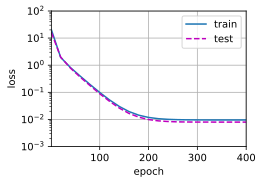

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.312748  3.9232702]]


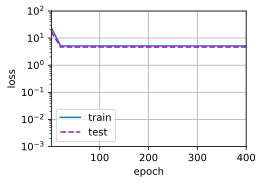

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9616737e+00  1.2487806e+00 -3.2416661e+00  5.3349671e+00
  -4.5600554e-01  1.0531688e+00 -1.4854915e-01  1.7104911e-02
  -4.6477526e-02 -3.6001101e-02 -2.7045500e-02 -2.0875797e-02
  -1.9044103e-02 -5.4703718e-03 -5.3084670e-03 -6.1084172e-03
   1.1557042e-02 -3.9350931e-03 -1.2609677e-02  1.2241902e-02]]


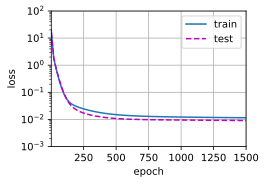

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)